<a href="https://colab.research.google.com/github/SCBrazil14/Brackets-css-color-preview/blob/master/ML_Flux_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML/FLux Tutorial

by Gordon MacMillan

## 0. Google Colaboratory

This environment is meant to be used in Google Colaboratory so that the user can take advantage of Google cloud hardware accelerators. A Python 3 environment is the default for Colab notebooks, but a hack can be used to install and run a Julia Kernel.

Using Colab is free with a few constraint on how long a session can run, how many sessions can be run concurrently, what exact GPU hardware is allocated. The full details are available on the follow FAQ: https://research.google.com/colaboratory/faq.html

To run this, you obviously need access to the notebook within Colab. Colab makes it very easy either to use github notebooks:

- From within colab, you can `File>Open` a notebook. A tab called Github enables quick access to repositories.

- Simpler, just click on the button at the top of this page.



## 1. Setting up environment

The below code will download and install dependencies so that this hack can be applied and Julia becoming available as kernel. Please execute the following cell.

In [1]:
!curl -sSL "https://julialang-s3.julialang.org/bin/linux/x64/1.3/julia-1.3.0-linux-x86_64.tar.gz" -o julia.tar.gz
!tar -xzf julia.tar.gz -C /usr --strip-components 1
!rm -rf julia.tar.gz*
!julia -e 'using Pkg; pkg"add IJulia; add CuArrays; add CUDAnative; add CUDAdrv; add Flux; add BenchmarkTools; add MLDatasets; add ImageMagick; add ImageCore; add Plots; precompile"'

   Cloning default registries into `~/.julia`
   Cloning registry from "https://github.com/JuliaRegistries/General.git"
     Added registry `General` to `~/.julia/registries/General`
 Resolving package versions...
 Installed MozillaCACerts_jll ─ v2024.11.26+0
 Installed LibSSH2_jll ──────── v1.9.0+3
 Installed ArgTools ─────────── v1.1.1
 Installed NetworkOptions ───── v1.2.0
 Installed Parsers ──────────── v2.4.2
 Installed IJulia ───────────── v1.24.2
 Installed TOML ─────────────── v1.0.3
 Installed PrecompileTools ──── v1.2.1
 Installed MbedTLS_jll ──────── v2.16.8+1
 Installed JLLWrappers ──────── v1.6.1
 Installed libsodium_jll ────── v1.0.19+0
 Installed JSON ─────────────── v0.21.4
 Installed LibCURL_jll ──────── v7.70.0+2
 Installed Downloads ────────── v1.6.0
 Installed Artifacts ────────── v1.3.0
 Installed nghttp2_jll ──────── v1.40.0+2
 Installed Preferences ──────── v1.4.3
 Installed Conda ────────────── v1.10.2
 Installed VersionParsing ───── v1.3.0
 Installed MbedTLS ──

Now a full Julia environment is available. To use it, two choices:

Change the notebook settings: click on `Edit > Notebook Settings` and select `julia`. Even if the kernel is already selected, click on `save`.

Alternatively, refresh the page with *** Ctrl-r***.

### Set up some Cuda arrays and test for GPU

Now the Julia environment should be ready to go. First, lets test to make sure the GPU is being utilized. You need to have CUDA available to use CuArrays.

But before that, let's make sure everything is fine:


In [1]:
[1, 2, 3]

3-element Array{Int64,1}:
 1
 2
 3

If this is a python kernel, it will be interpreted as list. But you should instead expect a Julia array and see:

```
3-element Array{Int64,1}:
 1
 2
 3
```

Now let's check that CUDA is fine reading which version is installed:

In [2]:
using CUDAdrv, CUDAnative
print(CUDAdrv.version())
print("\n")
print(CUDAnative.version())


12.2.0
10.2.89

┌ Warning: `haskey(::TargetIterator, name::String)` is deprecated, use `Target(; name=name) !== nothing` instead.
│   caller = llvm_compat(::VersionNumber) at compatibility.jl:176
└ @ CUDAnative ~/.julia/packages/CUDAnative/e0IdN/src/compatibility.jl:176


We can also see which hardware is allocated:

In [3]:
CUDAdrv.name(CuDevice(0))

"Tesla T4"

Let's try a few simple array operations to check:

In [4]:
using CuArrays

In [ ]:
W = cu(rand(2, 5)) # a 2×5 CuArray
b = cu(rand(2))

predict(x) = W*x .+ b
loss(x, y) = sum((predict(x) .- y).^2)

x, y = cu(rand(5)), cu(rand(2)) # Dummy data
loss(x, y) # ~ 3

0.4684248f0

In [5]:
function say(num)
    """print number using cuda threads"""
    @cuprintf("Thread %ld says: %ld\n",
              threadIdx().x, num)
    return
end

say (generic function with 1 method)

In [6]:
@cuda threads=8 say(42)

┌ Warning: `Target(triple::String)` is deprecated, use `Target(; triple=triple)` instead.
│   caller = ip:0x0
└ @ Core :-1


Thread 1 says: 42
Thread 2 says: 42
Thread 3 says: 42
Thread 4 says: 42
Thread 5 says: 42
Thread 6 says: 42
Thread 7 says: 42
Thread 8 says: 42


Better example: Apply function to array

In [7]:
a = CuArray([1., 2., 3.])
b = CuArray([3., -3., 6.])

function diff_sq(a, b)
    f = (x, y) -> (x - y)^2
    i = threadIdx().x
    a[i] = f(a[i], b[i])
    return
end

norm = x -> sqrt(sum(x))

@cuda threads = length(a) diff_sq(a, b)
norm(a)

6.164414002968976

In [8]:
f(x, y) = sum((x .- y).^2) |> gpu
# TODO: check if faster than the above

f (generic function with 1 method)

In [9]:
using Flux: Conv, gpu
using BenchmarkTools

### Benchmark image convolution test

In [10]:
random_image_cpu = randn(100, 100, 3, 100)
random_image_gpu = cu(randn(100, 100, 3, 100))

m = Conv((7, 7), 3 => 64)

println("""Time (s) to convolve 7x7x3 filter over random 100x100x3x100 images
        (width x height x channel x batch).""")
println("CPU (s):")
@btime m(random_image_cpu);

m = Conv((7, 7), 3 => 3) |> gpu

println("GPU (s):")
@btime m(random_image_gpu);

Time (s) to convolve 7x7x3 filter over random 100x100x3x100 images
(width x height x channel x batch).
CPU (s):
  10.608 s (42 allocations: 862.89 MiB)
GPU (s):
  51.338 μs (291 allocations: 11.56 KiB)


TODO: Perform a benchmark of julia wrapper for tensorflow:  [TensorFlow.jl](https://github.com/malmaud/TensorFlow.jl)

## 2. Use Case: Fashion MNIST


In [12]:
using MLDatasets
FashionMNIST.download(i_accept_the_terms_of_use=true)

# load full training set
train_x, train_y = FashionMNIST.traindata();

# load full test set
test_x,  test_y  = FashionMNIST.testdata();

┌ Info: Downloading
│   source = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz"
│   dest = "/root/.julia/datadeps/FashionMNIST/t10k-labels-idx1-ubyte.gz"
│   progress = 1.0
│   time_taken = "0.0 s"
│   time_remaining = "0.0 s"
│   average_speed = "∞ B/s"
│   downloaded = "5.027 KiB"
│   remaining = "0 bytes"
└   total = "5.027 KiB"
┌ Info: Downloading
│   source = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz"
│   dest = "/root/.julia/datadeps/FashionMNIST/train-labels-idx1-ubyte.gz"
│   progress = 1.0
│   time_taken = "0.16 s"
│   time_remaining = "0.0 s"
│   average_speed = "176.830 KiB/s"
│   downloaded = "28.823 KiB"
│   remaining = "0 bytes"
└   total = "28.823 KiB"
┌ Info: Downloading
│   source = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz"
│   dest = "/root/.julia/datadeps/FashionMNIST/t10k-images-idx3-ubyte.gz"
│   progress = 1.0
│   time_taken = "0.34 s"


ErrorException: [91merror compiling traindata: error compiling gzopen: error compiling gzopen: could not load library "libc"[39m
[91m/lib/x86_64-linux-gnu/libc.so: invalid ELF header[39m

In [13]:
julia
using MLDatasets

# Download the dataset if it's not already downloaded.
# The `force=true` argument ensures it's downloaded even if it exists.
FashionMNIST.download(i_accept_the_terms_of_use=true, force=true)

# Try loading the data again.
train_x, train_y = FashionMNIST.traindata()
test_x, test_y = FashionMNIST.testdata()

UndefVarError: [91mUndefVarError: julia not defined[39m

In [14]:
# Remove the 'julia' keyword from the first line.
# The notebook kernel should be set to Julia for this cell to execute correctly.
# If the kernel is not set to Julia, go to "Kernel" -> "Change kernel" -> "Julia"
# in the Jupyter notebook menu.

using MLDatasets

# Download the dataset if it's not already downloaded.
# The `force=true` argument ensures it's downloaded even if it exists.
FashionMNIST.download(i_accept_the_terms_of_use=true, force=true)

# Try loading the data again.
train_x, train_y = FashionMNIST.traindata()
test_x, test_y = FashionMNIST.testdata()

MethodError: [91mMethodError: no method matching download(::DataDeps.DataDep{String,Array{String,1},typeof(DataDeps.fetch_default),typeof(identity)}, ::String; i_accept_the_terms_of_use=true, force=true)[39m
[91m[0mClosest candidates are:[39m
[91m[0m  download(::DataDeps.DataDep, ::Any; remotepath, i_accept_the_terms_of_use, skip_checksum) at /root/.julia/packages/DataDeps/jDkzU/src/resolution_automatic.jl:70[91m got unsupported keyword argument "force"[39m[39m
[91m[0m  download([91m::AbstractString[39m, ::AbstractString) at download.jl:59[91m got unsupported keyword arguments "i_accept_the_terms_of_use", "force"[39m[39m

In [15]:
using MLDatasets

# Download the dataset if it's not already downloaded.
# The `force=true` argument is not supported, so it's removed.
# If you want to force a re-download, you may need to manually delete the existing dataset files.
FashionMNIST.download(i_accept_the_terms_of_use=true)

# Try loading the data again.
train_x, train_y = FashionMNIST.traindata()
test_x, test_y = FashionMNIST.testdata()

┌ Info: Downloading
│   source = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz"
│   dest = "/root/.julia/datadeps/FashionMNIST/train-labels-idx1-ubyte.gz"
│   progress = 1.0
│   time_taken = "0.17 s"
│   time_remaining = "0.0 s"
│   average_speed = "168.557 KiB/s"
│   downloaded = "28.823 KiB"
│   remaining = "0 bytes"
└   total = "28.823 KiB"
┌ Info: Downloading
│   source = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz"
│   dest = "/root/.julia/datadeps/FashionMNIST/t10k-labels-idx1-ubyte.gz"
│   progress = 1.0
│   time_taken = "0.0 s"
│   time_remaining = "0.0 s"
│   average_speed = "∞ B/s"
│   downloaded = "5.027 KiB"
│   remaining = "0 bytes"
└   total = "5.027 KiB"
┌ Info: Downloading
│   source = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz"
│   dest = "/root/.julia/datadeps/FashionMNIST/t10k-images-idx3-ubyte.gz"
│   progress = 1.0
│   time_taken = "1.38 s"


ErrorException: [91merror compiling traindata: error compiling gzopen: error compiling gzopen: could not load library "libc"[39m
[91m/lib/x86_64-linux-gnu/libc.so: invalid ELF header[39m

In [16]:
julia
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: partition
using Random
using CUDA

# Load the MNIST dataset
# The dataset will be downloaded if it is not already present
train_x, train_y = MNIST.traindata()
test_x,  test_y  = MNIST.testdata()

UndefVarError: [91mUndefVarError: julia not defined[39m

In [17]:
julia
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: partition
using Random
using CUDA

# Load the MNIST dataset
# The dataset will be downloaded if it is not already present
train_x, train_y = MNIST.traindata()
test_x,  test_y  = MNIST.testdata()

UndefVarError: [91mUndefVarError: julia not defined[39m

In [18]:
julia
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: partition
using Random
using CUDA

# Load the MNIST dataset
# The dataset will be downloaded if it is not already present
train_x, train_y = MNIST.traindata()
test_x,  test_y  = MNIST.testdata()

UndefVarError: [91mUndefVarError: julia not defined[39m

In [19]:
julia
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: partition
using Random
using CUDA

# Load the MNIST dataset
# The dataset will be downloaded if it is not already present
train_x, train_y = MNIST.traindata()
test_x,  test_y  = MNIST.testdata()

UndefVarError: [91mUndefVarError: julia not defined[39m

In [ ]:
using ImageCore
FashionMNIST.convert2image(FashionMNIST.traintensor(4))

In [ ]:
@doc(FashionMNIST.convert2image) # same as `? FashionMNIST.convert2image`

UndefVarError: UndefVarError: FashionMNIST not defined

In [ ]:
using Flux, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle, params
using Statistics: mean
using Base.Iterators: partition
using Random
Random.seed!(32)

MersenneTwister(UInt32[0x00000020], Random.DSFMT.DSFMT_state(Int32[362167519, 1073538041, 791601329, 1072922344, -1200180471, 1073405548, 802389604, 1073721749, 1597631051, 1072866084  …  -752455786, 1072947302, -470736313, 1073186836, -1839481848, -1674302192, 1144353388, 772375038, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000

In [ ]:
@info("Constructing MLP model...")
model() = Chain(
  Conv((5, 5), 1 => 64, elu, pad=(2, 2), stride=(1, 1)),
  BatchNorm(64),
  MaxPool((3, 3), pad=(2, 2), stride=(2, 2)),
  Dropout(0.25),
  Conv((5, 5), 64 => 128, elu, pad=(2, 2), stride=(1, 1)),
  BatchNorm(128),
  MaxPool((2, 2), stride=(2, 2)),
  Dropout(0.25),
  Conv((5, 5), 128 => 256, elu, pad=(2, 2), stride=(1, 1)),
  BatchNorm(256),
  MaxPool((2, 2), stride=(2, 2)),
  Dropout(0.25),
  x -> reshape(x, :, size(x, 4)),
  Dense(2304, 256, elu),
  Dropout(0.5),
  Dense(256, 10),
  softmax) |> gpu

┌ Info: Constructing MLP model...
└ @ Main In[15]:1


model (generic function with 1 method)

In [ ]:
N = size(train_x)[end]

# random permute train indexes
ixs = collect(1:N)
shuffle!(ixs)
n = Int(floor(.9 * N))

# batch size
bs = 100
sz = (28, 28, 1, bs)

# 90/10 hold out split
train_split, val_split = ixs[1:n], ixs[n + 1:end]

train_data = train_x[:, :, train_split], train_y[train_split]
val_data = train_x[:, :, val_split], train_y[val_split]
test_data = test_x, test_y

```
Make batches of x, y data

returns: list of tuples
```
function make_batches(data; bs=100)
    n = size(data[1])[end]
    sz = (28, 28, 1, bs)
    iter = [(reshape(Float32.(data[1][:, :, i]), sz), onehotbatch(data[2][i], 0:9)) for i in partition(1:n, bs)] |> gpu
end

train = make_batches(train_data)
val = make_batches(val_data)
test = make_batches(test_data);

### Testing the forward pass on a single image

In [ ]:
m = model()

Chain(Conv((5, 5), 1=>64, elu), BatchNorm(64), MaxPool((3, 3), pad = (2, 2), stride = (2, 2)), Dropout(0.25), Conv((5, 5), 64=>128, elu), BatchNorm(128), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Dropout(0.25), Conv((5, 5), 128=>256, elu), BatchNorm(256), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Dropout(0.25), #9, Dense(2304, 256, elu), Dropout(0.5), Dense(256, 10), softmax)

In [ ]:
img = reshape(train[1][1][:, :, :, 1], (28, 28, 1, 1))
# img = reshape(val[1][1][:, :, :, 1], (28, 28, 1, 1))

28×28×1×1 CuArray{Float32,4,CuArray{Float32,3,Nothing}}:
[:, :, 1, 1] =
 0.0         0.0         0.0         …  0.0         0.0       0.0      
 0.0         0.0         0.0            0.0         0.0       0.0      
 0.0         0.0         0.0            0.0         0.0       0.0      
 0.0         0.0         0.0            0.0         0.0       0.0      
 0.0         0.0         0.0            0.0         0.0       0.0      
 0.0         0.0         0.0         …  0.0         0.0       0.0      
 0.0         0.0         0.00392157     0.0         0.0       0.0      
 0.0         0.0         0.0            0.0         0.0       0.0      
 0.0         0.0         0.0196078      0.0         0.0       0.0      
 0.0         0.0         0.435294       0.301961    0.266667  0.0784314
 0.0         0.133333    0.384314    …  0.364706    0.435294  0.313726 
 0.0         0.321569    0.309804       0.14902     0.298039  0.341176 
 0.0         0.266667    0.337255       0.584314    0.631373  0.

In [ ]:
m(img)

10×1 CuArray{Float32,2,Nothing}:
 0.10063214 
 0.09824421 
 0.10722762 
 0.09882989 
 0.09707087 
 0.0917206  
 0.100451134
 0.09807167 
 0.10925116 
 0.09850067 

### Train on loss function for one Epoch

Submitting a callback function can be used to interupt the execution of a training loop after each batch to compute test statistics.



In [ ]:
eval_acc = []
batch_idx = 0

```
Defines accuracy metric to compute on data set
Pushes computed value to eval_acc array
Increments the batch index
```
function calc_metrics(data)
    global batch_idx
    acc = 0
    for batch in data
        x, y = batch
        pred = m(x) .> 0.5
        tp = Float32(sum((pred .+ y) .== Int16(2)))
        fp = Float32(sum((pred .- y) .== Int16(1)))
        fn = Float32(sum((pred .- y) .== Int16(-1)))
        tn = Float32(sum((pred .+ y) .== Int16(0)))
        acc += (tp + tn) / (tp + tn + fp + fn)
    end
    acc /= length(data)
    push!(eval_acc, acc)
    if batch_idx % 100 == 0
        @show(batch_idx)
    end

    batch_idx += 1
end

# Define the loss, callback and optimizer
loss(x, y) = crossentropy(m(x), y)
evalcb = () -> calc_metrics(val)
opt = ADAM()

# Start model training
Flux.train!(loss, params(m), train, opt, cb = evalcb)

batch_idx = 0
batch_idx = 100
batch_idx = 200
batch_idx = 300
batch_idx = 400
batch_idx = 500


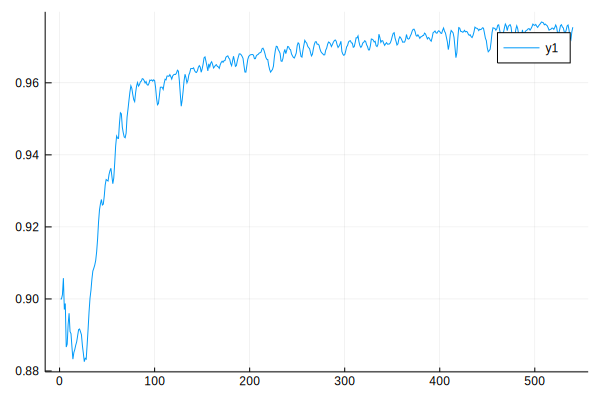

In [ ]:
using Plots
x = 1:length(train); y = eval_acc;
plot(x,y)

### Check the results (inference)

Now that training is complete, let's see how well the model can predict on the test set...

In [ ]:
eval_acc = [] # need to reset to calc test accuracy. this could be done better
calc_metrics(test)
println("accuracy on test data: ", eval_acc[1])

accuracy on test data: 0.9745399
